### 로지스틱 회귀분석   

오즈(Odds)와 로짓 변환(Logic Transformation)    

오즈란 사건이 발생할 확률을 발생하지 않을 확률과의 비율로 나타낸 값   
오즈 값을 로그 변환(로짓 변환)하면 선형 관계를 만들 수 있다.   
로그를 취한 오즈 값 범위는 무한하다. 이를 확률 값(0~1)로 변환하기 위해 시그모이드 함수를 적용한다.    

In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import *
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kamilpytlak/personal-key-indicators-of-heart-disease")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\KimDongyoung\.cache\kagglehub\datasets\kamilpytlak\personal-key-indicators-of-heart-disease\versions\6


In [6]:
# 데이터 불러오기
# https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease
df = pd.read_csv("C:/Users/KimDongyoung/.cache/kagglehub/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/versions/6/2020/heart_2020_cleaned.csv")

# 데이터 샘플 확인
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [7]:
# 컬럼 정보 확인

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [8]:
# 명목형 변수 더미처리

# 하나의 가변수 범주 제거 옵션 적용
df2 = pd.get_dummies(df, columns = ['HeartDisease','Smoking',
                                    'AlcoholDrinking','Stroke',
                                    'DiffWalking','Sex',
                                    'AgeCategory','Race',
                                    'Diabetic','PhysicalActivity',
                                    'GenHealth','Asthma',
                                    'KidneyDisease','SkinCancer']
                     ,drop_first=True
                    )

df2.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime,HeartDisease_Yes,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,...,Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_Yes,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
0,16.60,3.0,30.0,5.0,False,True,False,False,False,False,...,True,False,True,False,False,False,True,True,False,True
1,20.34,0.0,0.0,7.0,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False
2,26.58,20.0,30.0,8.0,False,True,False,False,False,True,...,True,False,True,True,False,False,False,True,False,False
3,24.21,0.0,0.0,6.0,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
4,23.71,28.0,0.0,8.0,False,False,False,False,True,False,...,False,False,True,False,False,False,True,False,False,False


In [9]:
# RobustScaler 적용

# 숫자형 변수 분리
df_num = df[['BMI','PhysicalHealth','MentalHealth','SleepTime']]
df_nom = df2.drop(['BMI','PhysicalHealth','MentalHealth','SleepTime'],axis=1)

# 숫자형 변수 RobustScaler 적용
RobustScaler = RobustScaler()
df_robust = RobustScaler.fit_transform(df_num)

# 컬럼명 결합
df_num2 = pd.DataFrame(data=df_robust, columns=df_num.columns)

# 숫자형 테이블과 더미화 문자형 테이블 결합
df3 = pd.concat([df_num2,df_nom],axis=1)

df3.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime,HeartDisease_Yes,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,...,Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_Yes,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
0,-1.453315,1.5,10.0,-1.0,False,True,False,False,False,False,...,True,False,True,False,False,False,True,True,False,True
1,-0.947226,0.0,0.0,0.0,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False
2,-0.102842,10.0,10.0,0.5,False,True,False,False,False,True,...,True,False,True,True,False,False,False,True,False,False
3,-0.423545,0.0,0.0,-0.5,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
4,-0.491204,14.0,0.0,0.5,False,False,False,False,True,False,...,False,False,True,False,False,False,True,False,False,False


In [10]:
# 독립변수와 종속변수 분리하여 생성
X = df3.drop(['HeartDisease_Yes'],axis=1)
y = df3[['HeartDisease_Yes']]

# 학습셋과 테스트셋 분리하여 생성(7.5:2.5)
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.25,random_state=10)

# 학습셋과 검증셋이 잘 나뉘었는지 확인
print('train data 개수: ', len(X_train))
print('test data 개수: ', len(X_test))

train data 개수:  239846
test data 개수:  79949


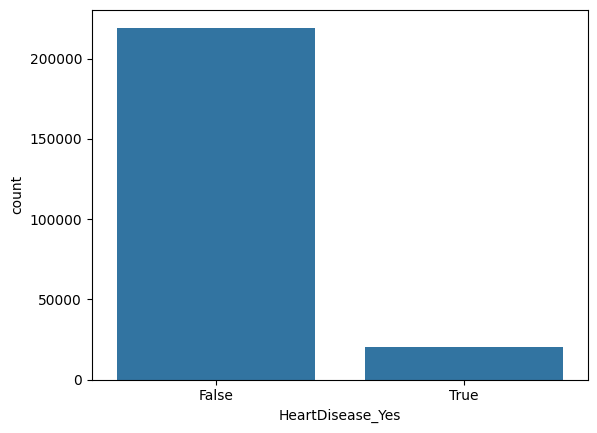

In [11]:
# HeartDisease_Yes 컬럼 클래스 분포 시각화
sns.countplot(x="HeartDisease_Yes", data=y_train)

plt.show()

In [12]:
# 임시 변수명 적용

X_train_re = X_train.copy()
y_train_re = y_train.copy()

X_temp_name = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10',
            'X11','X12','X13','X14','X15','X16','X17','X18','X19','X20',
            'X21','X22','X23','X24','X25','X26','X27','X28','X29','X30',
            'X31','X32','X33','X34','X35','X36','X37']
y_temp_name = ['y1']


X_train_re.columns = X_temp_name
y_train_re.columns = y_temp_name

X_train_re.head()


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37
163572,-0.202977,0.0,0.0,-0.5,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
150901,1.476319,0.0,0.0,0.5,True,False,True,False,True,False,...,False,False,True,False,False,False,True,False,False,False
164527,-0.248985,15.0,10.0,-2.0,True,False,False,True,True,False,...,False,False,True,False,False,True,False,False,False,False
260971,0.805142,0.0,0.0,0.0,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,False
262287,0.612991,5.0,0.0,0.0,False,False,False,False,True,False,...,True,False,True,False,True,False,False,False,False,False


In [13]:
# 언더샘플링 적용

X_train_under, y_train_under = RandomUnderSampler(
    random_state=0).fit_resample(X_train_re,y_train_re)

print('RandomUnderSampler 적용 전 학습셋 변수/레이블 데이터 세트: '
      , X_train_re.shape, y_train_re.shape)
print('RandomUnderSampler 적용 후 학습셋 변수/레이블 데이터 세트: '
      , X_train_under.shape, y_train_under.shape)
print('RandomUnderSampler 적용 전 레이블 값 분포: \n'
      , pd.Series(y_train_re['y1']).value_counts())
print('RandomUnderSampler 적용 후 레이블 값 분포: \n'
      , pd.Series(y_train_under['y1']).value_counts())

RandomUnderSampler 적용 전 학습셋 변수/레이블 데이터 세트:  (239846, 37) (239846, 1)
RandomUnderSampler 적용 후 학습셋 변수/레이블 데이터 세트:  (41036, 37) (41036, 1)
RandomUnderSampler 적용 전 레이블 값 분포: 
 y1
False    219328
True      20518
Name: count, dtype: int64
RandomUnderSampler 적용 후 레이블 값 분포: 
 y1
False    20518
True     20518
Name: count, dtype: int64


In [14]:
# 컬럼명 복구
X_train_under.columns = list(X_train)
y_train_under.columns = list(y_train)

X_train_under.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,AgeCategory_25-29,...,Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_Yes,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
69819,-0.572395,0.0,1.666667,0.5,False,False,False,False,True,False,...,False,False,True,False,True,False,False,False,False,False
248332,2.365359,6.0,0.333333,-0.5,False,False,False,False,False,False,...,True,False,True,True,False,False,False,False,False,False
31381,-0.964817,0.0,2.666667,0.5,False,False,False,False,True,False,...,False,False,True,False,False,False,True,True,False,False
152264,-1.246279,0.0,0.000000,-0.5,True,False,False,True,True,False,...,False,False,True,False,True,False,False,True,False,False
90674,0.668471,15.0,0.000000,0.5,True,False,False,False,True,False,...,True,False,True,True,False,False,False,False,False,False


In [15]:
# 학습셋 모델 학습

model = LogisticRegression()
model.fit(X_train_under, y_train_under)

print('학습셋 모델 정확도:', model.score(X_train_under, y_train_under))

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


학습셋 모델 정확도: 0.7645969392728336


In [16]:
# 테스트셋 모델 적합

print('테스트셋 모델 정확도:', model.score(X_test, y_test))

테스트셋 모델 정확도: 0.7501532226794582


In [17]:
# 계수값 확인

print(model.coef_)

[[ 8.00552949e-02  1.18985925e-02  2.93471054e-02 -5.47161400e-02
   4.06132541e-01 -2.46564747e-01  1.28132053e+00  2.00103625e-01
   7.59860641e-01 -5.77022168e-02  3.97579667e-01  4.15781597e-01
   7.87305886e-01  1.07625077e+00  1.52827757e+00  1.76608419e+00
   2.04618659e+00  2.33239770e+00  2.68454209e+00  2.84133565e+00
   3.20264291e+00 -5.28907964e-01 -2.43464369e-01 -1.83591156e-01
  -9.68689056e-02 -5.98429544e-02  2.81304239e-01  4.80119093e-01
   4.37371189e-01 -1.85997211e-03  1.49909525e+00  1.02741861e+00
   1.81052971e+00  4.45403371e-01  2.94806407e-01  6.17099932e-01
   1.41363434e-01]]


In [25]:
print(X_train_under.dtypes)
print(y_train_under.dtypes)

BMI                              float64
PhysicalHealth                   float64
MentalHealth                     float64
SleepTime                        float64
Smoking_Yes                         bool
AlcoholDrinking_Yes                 bool
Stroke_Yes                          bool
DiffWalking_Yes                     bool
Sex_Male                            bool
AgeCategory_2529                    bool
AgeCategory_3034                    bool
AgeCategory_3539                    bool
AgeCategory_4044                    bool
AgeCategory_4549                    bool
AgeCategory_5054                    bool
AgeCategory_5559                    bool
AgeCategory_6064                    bool
AgeCategory_6569                    bool
AgeCategory_7074                    bool
AgeCategory_7579                    bool
AgeCategory_80orolder               bool
Race_Asian                          bool
Race_Black                          bool
Race_Hispanic                       bool
Race_Other      

In [26]:
# x_train_under를 float로 변환
X_train_under = X_train_under.astype(float)
# y_train_under를 int로 변환
y_train_under = y_train_under.astype(float)

In [27]:
print(X_train_under.dtypes)
print(y_train_under.dtypes)

BMI                              float64
PhysicalHealth                   float64
MentalHealth                     float64
SleepTime                        float64
Smoking_Yes                      float64
AlcoholDrinking_Yes              float64
Stroke_Yes                       float64
DiffWalking_Yes                  float64
Sex_Male                         float64
AgeCategory_2529                 float64
AgeCategory_3034                 float64
AgeCategory_3539                 float64
AgeCategory_4044                 float64
AgeCategory_4549                 float64
AgeCategory_5054                 float64
AgeCategory_5559                 float64
AgeCategory_6064                 float64
AgeCategory_6569                 float64
AgeCategory_7074                 float64
AgeCategory_7579                 float64
AgeCategory_80orolder            float64
Race_Asian                       float64
Race_Black                       float64
Race_Hispanic                    float64
Race_Other      

In [28]:
# 다른 로지스틱 모델로 학습

model2 = sm.Logit(y_train_under, X_train_under)
results = model2.fit(method = "newton") 

results.summary()

Optimization terminated successfully.
         Current function value: 0.503919
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       HeartDisease_Yes   No. Observations:                41036
Model:                          Logit   Df Residuals:                    40999
Method:                           MLE   Df Model:                           36
Date:                Wed, 07 May 2025   Pseudo R-squ.:                  0.2730
Time:                        10:53:30   Log-Likelihood:                -20679.
converged:                       True   LL-Null:                       -28444.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
BMI                               0.0918      0.015      6.056      0.000       0.062       0.121
PhysicalHealth                    0.0114      0.003      3.367      0.001       0.005       0.018
MentalHealth                      0.0170      0.005      3.478      0.001       0.007       0.027
SleepTime                        -0.0733      0.016     -4.619      0.000      -0.104      -0.042
Smoking_Yes                       0.3696      0.025     14.807      0.000       0.321       0.419
AlcoholDrinking_Yes              -0.2732      0.053     -5.107      0.000      -0.378      -0.168
Stroke_Yes                        1.2616      0.054     23.555      0.000       1.157       1.367
DiffWalking_Yes                   0.1708      0.035      4.907      0.000       0.103       0.239
Sex_Male                          0.6680      0.025     26.580      0.000       0.619       0.717
AgeCategory_2529                 -1.4044      0.127    -11.088      0.000      -1.653      -1.156
AgeCategory_3034                 -0.9200      0.103     -8.905      0.000      -1.122      -0.717
AgeCategory_3539                 -0.9326      0.097     -9.634      0.000      -1.122      -0.743
AgeCategory_4044                 -0.5486      0.089     -6.190      0.000      -0.722      -0.375
AgeCategory_4549                 -0.2661      0.082     -3.244      0.001      -0.427      -0.105
AgeCategory_5054                  0.1993      0.076      2.636      0.008       0.051       0.348
AgeCategory_5559                  0.4354      0.072      6.049      0.000       0.294       0.576
AgeCategory_6064                  0.7295      0.070     10.414      0.000       0.592       0.867
AgeCategory_6569                  1.0211      0.070     14.680      0.000       0.885       1.157
AgeCategory_7074                  1.3695      0.070     19.549      0.000       1.232       1.507
AgeCategory_7579                  1.5302      0.073     20.958      0.000       1.387       1.673
AgeCategory_80orolder             1.8668      0.072     25.936      0.000       1.726       2.008
Race_Asian                       -2.6688      0.120    -22.307      0.000      -2.903      -2.434
Race_Black                       -2.3371      0.081    -28.721      0.000      -2.497      -2.178
Race_Hispanic                    -2.3334      0.080    -29.136      0.000      -2.490      -2.176
Race_Other                       -2.2070      0.093    -23.681      0.000      -2.390      -2.024
Race_White                       -2.1554      0.069    -31.379      0.000      -2.290      -2.021
Diabetic_Noborderlinediabetes     0.2903      0.078      3.734      0.000       0.138       0.443
Diabetic_Yes                      0.4801      0.032     14.907      0.000       0.417       0.543
Diabetic_Yesduringpregnancy       0.2256      0.164      1.376      0.169      -0.096       0.547
PhysicalActivity_Yes             -0.1670      0.029     -5.835      0.000      -0.223      -0.111
GenHeal

In [29]:
# 오즈비 확인

np.exp(results.params)

BMI                              1.096091
PhysicalHealth                   1.011469
MentalHealth                     1.017101
SleepTime                        0.929300
Smoking_Yes                      1.447148
AlcoholDrinking_Yes              0.760970
Stroke_Yes                       3.530911
DiffWalking_Yes                  1.186292
Sex_Male                         1.950422
AgeCategory_2529                 0.245524
AgeCategory_3034                 0.398530
AgeCategory_3539                 0.393534
AgeCategory_4044                 0.577770
AgeCategory_4549                 0.766331
AgeCategory_5054                 1.220555
AgeCategory_5559                 1.545532
AgeCategory_6064                 2.074125
AgeCategory_6569                 2.776307
AgeCategory_7074                 3.933446
AgeCategory_7579                 4.619038
AgeCategory_80orolder            6.467417
Race_Asian                       0.069335
Race_Black                       0.096610
Race_Hispanic                    0